<a href="https://colab.research.google.com/github/withjungjh/My-Neuromatch-Academy/blob/main/LSTM_example_%EC%A3%BC%EA%B0%80%EC%98%88%EC%B8%A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Set up

In [1]:
!pip3 install torch
!pip3 install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip3 install --upgrade pandas
!pip3 install --upgrade pandas_datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 2. 주식 정보 불러오기
neural data를 가지고 하면 좋겠지만 일단 LSTM을 처음 돌려보는 상황이기 때문에, 일단 빠르게 LSTM의 실질적인 input이 어떤 데이터로 들어가는지 확인하고자 주가 정보를 이용하였다. 

In [5]:
start = (2000, 1, 1) # 2000년 01월 01일
start = datetime.datetime(*start)
end = datetime.date.today()# 오늘

# 야후에서 google 불러오기
df = pdr.DataReader('GOOGL', 'yahoo', start, end)


`datetime.datetime(*start)` 에서 `*`의 의미는?

In [6]:
df.head(5)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2004-08-19,2.604104,2.401401,2.502503,2.511011,893181924.0,2.511011
2004-08-20,2.729730,2.515015,2.527778,2.710460,456686856.0,2.710460
2004-08-23,2.839840,2.728979,2.771522,2.737738,365122512.0,2.737738
2004-08-24,2.792793,2.591842,2.783784,2.624374,304946748.0,2.624374
2004-08-25,2.702703,2.599600,2.626627,2.652653,183772044.0,2.652653


In [7]:
df.tail(5)


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-09-07,109.980003,106.900002,107.059998,109.449997,23167000.0,109.449997
2022-09-08,109.599998,107.160004,108.040001,108.379997,24238300.0,108.379997
2022-09-09,110.989998,109.019997,109.070000,110.650002,23197700.0,110.650002
2022-09-12,111.620003,109.930000,110.989998,110.860001,22966800.0,110.860001
2022-09-13,108.300003,104.089996,107.800003,104.320000,38128100.0,104.320000


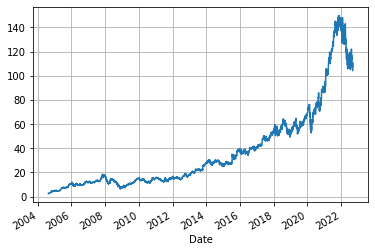

In [8]:
df.Close.plot(grid=True)

여기에서는 pandas를 데이터로 받았다. 상황에 따라서 다른 구조의 data도 받을 텐데 그때 어떻게 적용해야 할지 생각해보도록 하자. 

# 3. Preparing Dataset


In [14]:
X = df.drop(columns="Volume")
y = df.iloc[:, 5:6]
# y = df.iloc[:, 5] >>> column name이 나오지 않음. 

print(X)
print(y)

                  High         Low        Open       Close   Adj Close
Date                                                                  
2004-08-19    2.604104    2.401401    2.502503    2.511011    2.511011
2004-08-20    2.729730    2.515015    2.527778    2.710460    2.710460
2004-08-23    2.839840    2.728979    2.771522    2.737738    2.737738
2004-08-24    2.792793    2.591842    2.783784    2.624374    2.624374
2004-08-25    2.702703    2.599600    2.626627    2.652653    2.652653
...                ...         ...         ...         ...         ...
2022-09-07  109.980003  106.900002  107.059998  109.449997  109.449997
2022-09-08  109.599998  107.160004  108.040001  108.379997  108.379997
2022-09-09  110.989998  109.019997  109.070000  110.650002  110.650002
2022-09-12  111.620003  109.930000  110.989998  110.860001  110.860001
2022-09-13  108.300003  104.089996  107.800003  104.320000  104.320000

[4549 rows x 5 columns]
             Adj Close
Date                  
2004-0

`iloc` 무슨 함수인지 항상 까먹는다. 

## 데이터 정규화(Normalization and Standardization)

학습을 잘 시키기 위해서. 
왜 normalization을 하면 학습이 잘 되는가? 
feature scaling을 함으로서 feature scale에 덜 민감해지기 때문에. 
어떤 feature의 scale이 큰 경우에 다른 feature들을 압도할 수 있기 때문에 중요. 

- normalization through `MinMaxScaler()`
- standardization through `StandardScaler()`

In [15]:
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X) #
y_mm = mm.fit_transform(y)

# Training data : 처음부터 4499th row까지
X_train = X_ss[:4500, :] 
y_train = y_mm[:4500, :]

# Test data: 4500th row부터 끝까지
X_test = X_ss[4500:, :]
y_test = y_mm[4500:, :]

print("Training Shape:", X_train.shape, y_train.shape)
print("Test Shape:", X_test.shape, y_test.shape)

Training Shape: (4500, 5) (4500, 1)
Test Shape: (49, 5) (49, 1)


In [17]:
print(type(X))
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


그런데 이 상태에서는 왜 인지 블로그에서 학습이 불가능하다고 한다. 참고로 `fit_transform`을 하면서 pandas.DataFrame -> ndarray로 데이터 타입이 바뀌었다. 그런데 pytorch나 tensorflow등의 딥러닝 관련 라이브러리에서 학습이 가능하기 위해서는 tensor로 변환을 시켜줘야 하는 과정이 필요한 듯하다. 따라서 아래와 같은 과정으로 데이터 타입을 또 변환시켜준다. 

In [18]:
X_train_tensors = Variable(torch.Tensor(X_train)) #torch.Tensor는 input을 ndarray로만 받나? 
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train)) 
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([49, 1, 5]) torch.Size([49, 1])


나는 항상 데이터 shape이 어떤 모양으로 나와서 들어가는지 헷갈린다. 아무래도 실제로 DNN structure를 짜거나 이해해야 하는 상황이 오면 단계별로 데이터 타입과 shape을 정리하면서 정보흐름이 어떻게 이어지는지 파악해야 좀 더 이해했다는 느낌을 받을 것 같다. 

# 4. GPU 준비하기 (없으면 CPU로)
이 단계가 사실 개인 컴퓨터에서 가장 까다로울 수 있는 부분이다. torch의 경우 ndivia GPU가 깔려있어야 하고 cuda를 깔거나 해야하는 부분이다. 사실 torch를 깔 때 본인의 컴퓨터 사양을 알고 거기에 맞게 pytorch를 깔아야 하는 부분이기도 해서 어쨌든 신경쓸게 많다. 나는 이런 귀찮은 걸 짧은 시간에 집중해서 하기 싫어서 colab으로 코드를 돌리고 있는 중이다.  코드는 다음과 같다. 그런데 이 코드가 과연 colab에서 정상 실행될지는 잘 모르겠다. 한번 확인해보자. 

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # device
# print(torch.cuda.get_device_name(0)) 이 코드는 실행이 되지 않는다. 



다행히 CPU로 실행이 되는듯 한데.. 사실 colab에서도 GPU로 실행시킬 수 있다. 위에 `런타임>런타임 유형 변경` 으로 가면 실행하는 연산 프로세스? 를 CPU와 GPU , TPU 로 바꿀 수 있는 옵션이 있다. 

# LSTM network 구성하기

In [ ]:
class LSTM1(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super(LSTM1, self).__init__()
    self.num_classes = num_classes
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.seq_length = seq_length

# Reference
https://coding-yoon.tistory.com/131